In [1]:
%cd ..

/Users/andrewma/Desktop/stat222/Economic_Networks


In [2]:
from econnet import data
from econnet import simulator
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
u = data.Use(2020)
s = data.Supply(2020)
c = data.C2CReqs(2020)
i = data.I2IReqs(2020)
t = data.I2I(2020)

In [4]:
# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
MARKER_SIZE = 20
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180 # sets the image quality

# Height and width per row and column of subplots
FIG_HEIGHT = 18
FIG_WIDTH = 16
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("Paired")

In [5]:
def get_min_elements_index(array, n):
    array_sort = np.sort(array)
    array_sort = array_sort[:n]
    ##
    index_min_elements = []
    for small_thing in array_sort:
        index_small = np.where(array == small_thing)
        index_small = int(index_small[0])
        index_min_elements.append(index_small)
    return index_min_elements
industry_names = data.pd.Series(data.Table.industries)

In [6]:
name = "Apparel"
n = 10 
shock = -0.3 
order = 10 
year = 2020

In [7]:
def plot_experiment(name = "Funds & trusts", n = 20, shock = -0.3, order = 10, year = 2020):
    
    temp = np.where(industry_names == name)
    index_name = int(temp[0])
    print(f'Industry: {name}, Degree: {shock}')

    ## define the background var's
    u = data.Use(year)
    t = data.I2I(year)
    H = data.I2IReqs(year).make_adjacency()
    y = u.table.loc["Value Added (producer prices)", :][:data.Table.nInd]
    dz = np.zeros(y.shape[0])
    dz[index_name] = shock
    
    for i in range(order):
        ## Delta function shock

        one_run = simulator.simulateOneTime(y=y, H=H, dz=dz)
        oar = np.array(one_run)
        value_change = pd.DataFrame(one_run)
        value_added = value_change.iloc[0,:].to_dict()
        #y = pd.Series(value_added.copy())
        dz = y.copy()
        
        ## relative shock calculation
        shock_effs_relative = oar / oar[0, :]
        shock_effs_relative = pd.DataFrame(shock_effs_relative)
        shock_effs_relative.columns = industry_names

        ## base on the last order, get the most effected industries
        index_most_effected = get_min_elements_index(shock_effs_relative.iloc[-1,:], n=n)
        shocks = shock_effs_relative.iloc[:,index_most_effected].columns
        s = shocks.to_list()
        A = t.table[s].loc[s]
        G = nx.from_pandas_adjacency(A)
    
        # We have to set the population attribute for each of the 14 nodes
        for i in list(G.nodes()):
            G.nodes[i]["value_added"] = value_added[i]

        # node colour is a list of degrees of nodes
        node_color = [G.degree(v, weight = 'weight') for v in G]
        node_color = [0.005 * nx.get_node_attributes(G, "value_added")[v] for v in G]
        # ## node size decided by dy
        node_size = [0.005 * nx.get_node_attributes(G, "value_added")[v] for v in G]
        # width of edge is a list of weight of edges 
        edge_width = [0.00005 * G[u][v]['weight'] for u, v in G.edges()]
        pos = nx.circular_layout(G)
        plt.figure(figsize=(24,16))
        nx.draw_networkx(G, pos = pos, node_size = node_size, 
                        node_color = node_color, ## node color determined by degree(connectedness) currently
                        alpha = 0.7, ## alpha decided by dz
                        with_labels = True, 
                        width = edge_width, 
                        edge_color ='.6', 
                        cmap = plt.cm.Blues, 
                        font_type = "bold",
                        font_size = 14,
                        font_color = "red")
        
    
        plt.axis('off')
        plt.tight_layout()
        
        '''
        plt.figure(figsize = (20,12))
        plt.plot(shock_effs_relative.iloc[:,index_most_effected], marker="x")
        plt.xlabel("effect order")
        plt.ylabel("Relative Change of 'Value Added'")
        plt.yscale('log')
        plt.title("Delta-function shock effects (relative)")

        ## make the legend outside left
        plt.legend(shock_effs_relative.columns[index_most_effected], 
            bbox_to_anchor=(1.04,0.5), 
            loc="center left", 
            borderaxespad=0)
        plt.show()
        '''

Industry: Apparel, Degree: -0.002


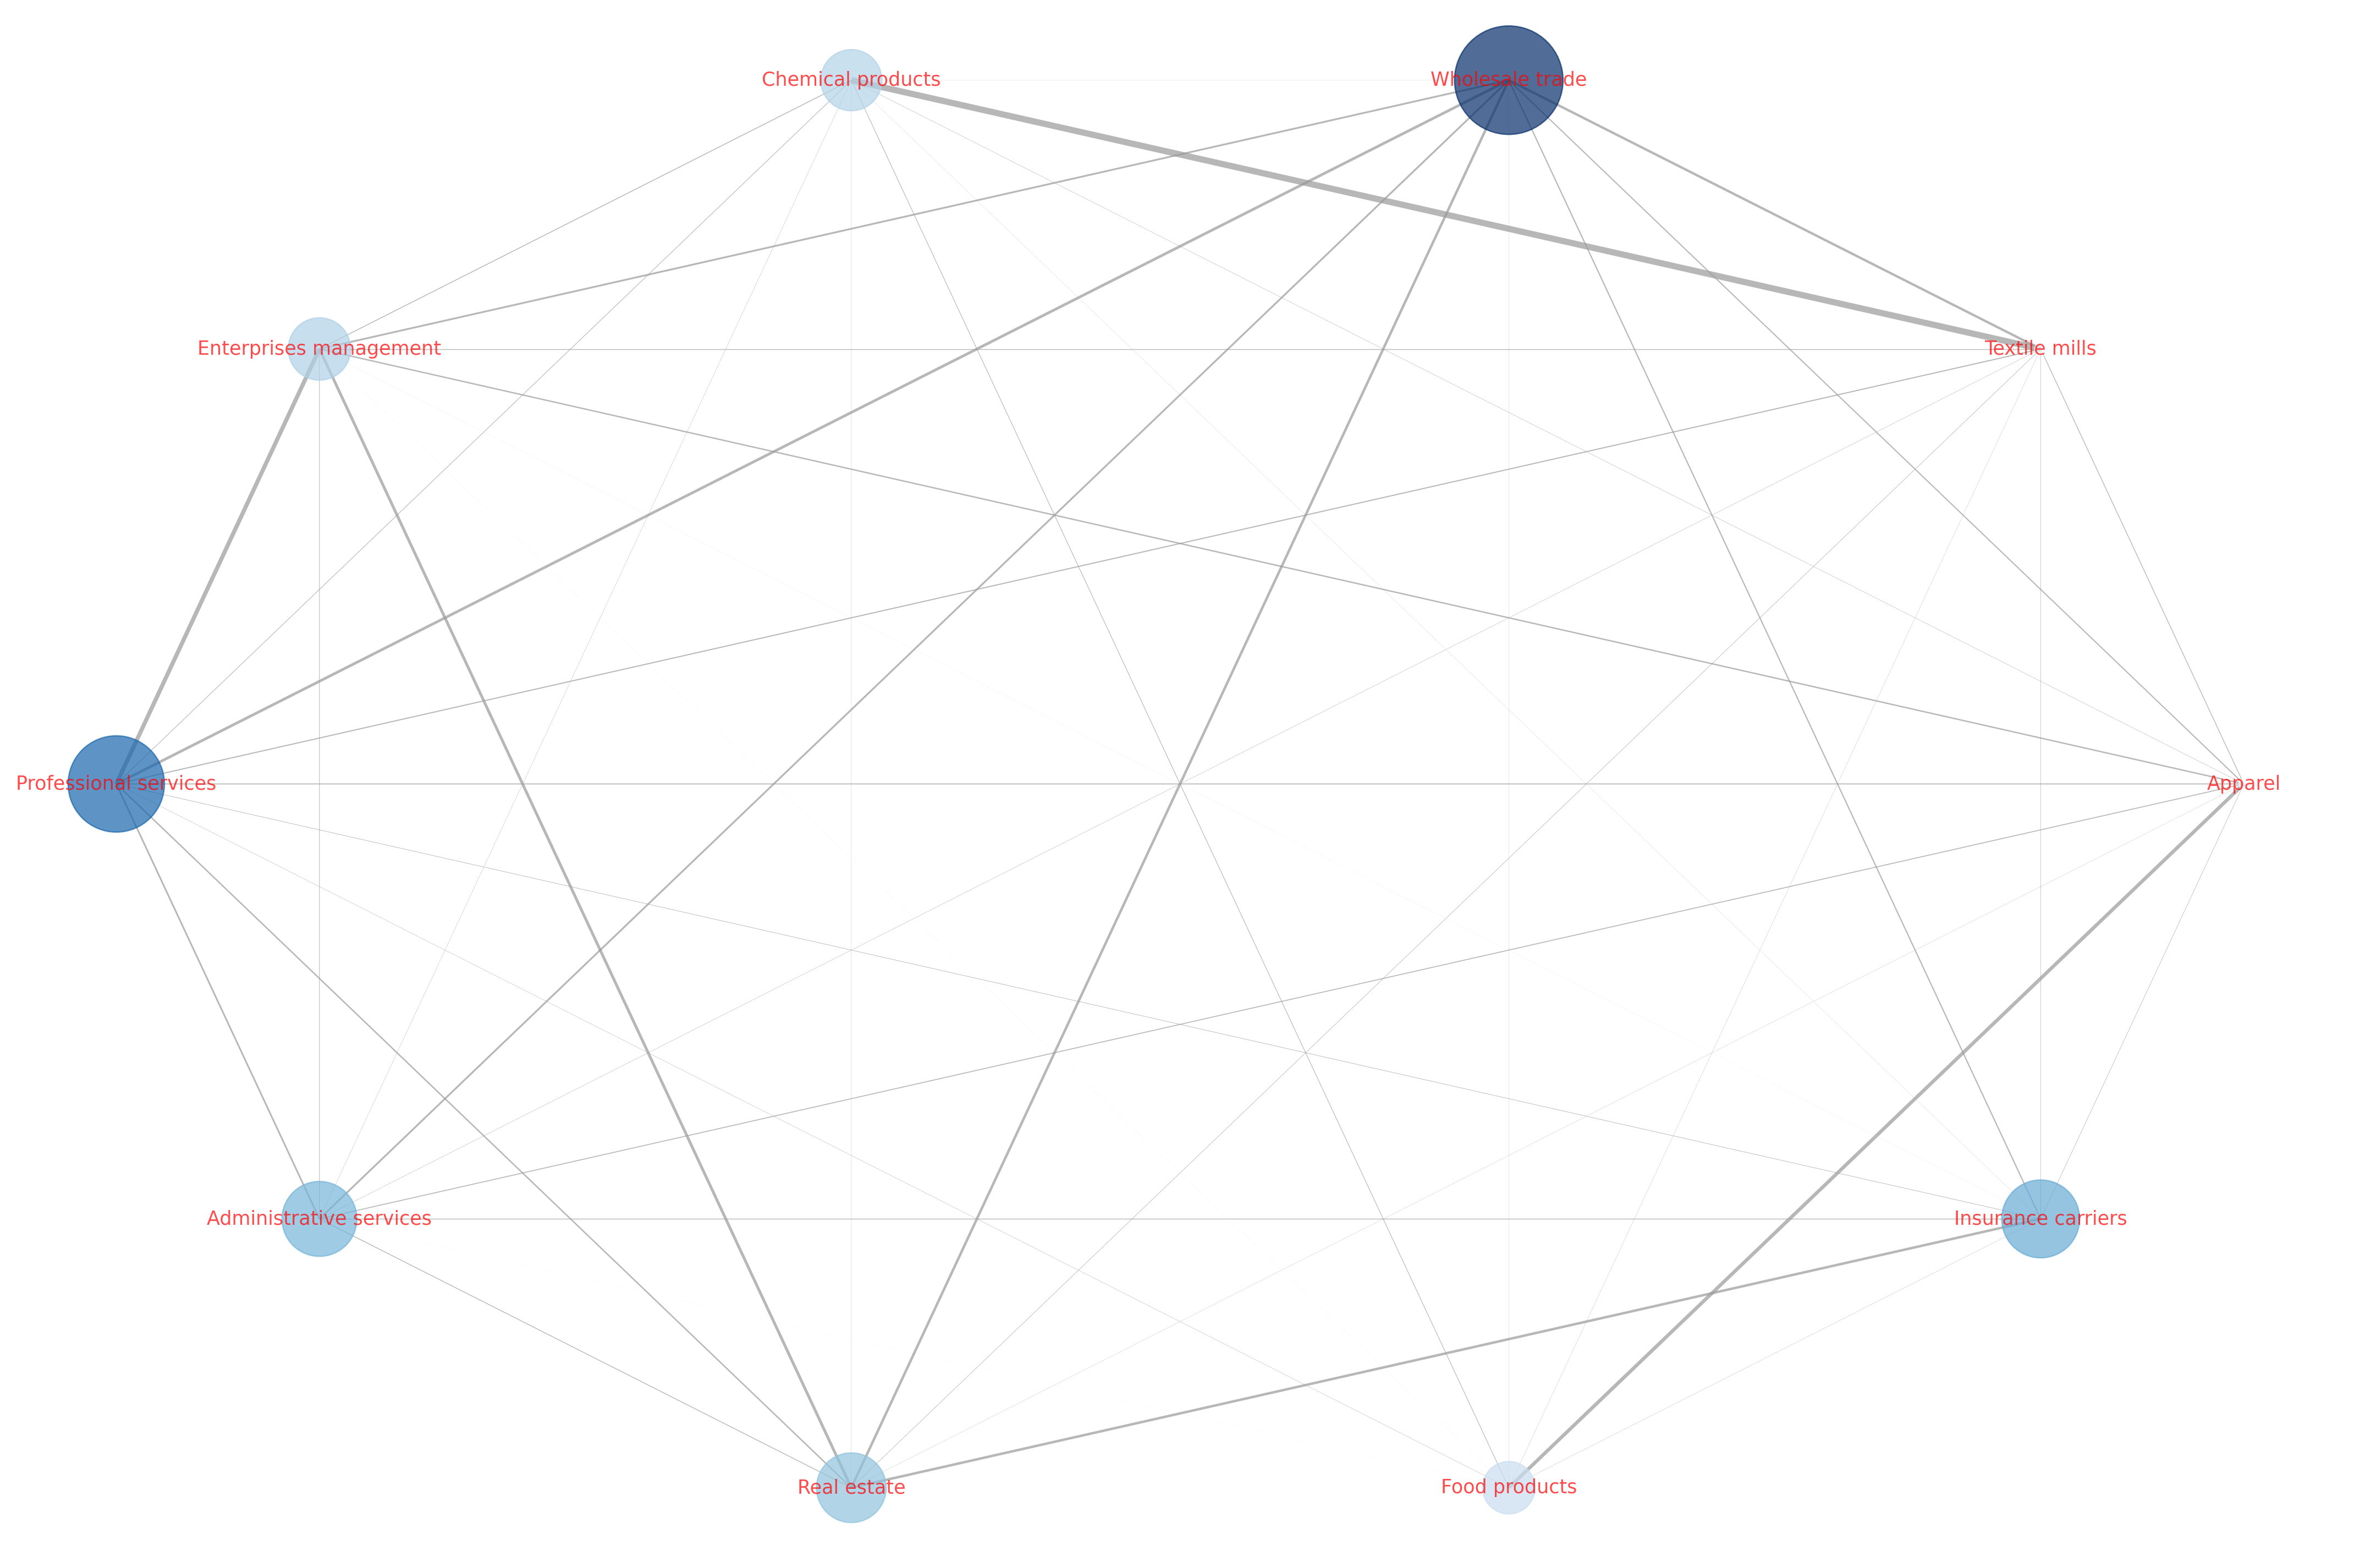

In [9]:
plot_experiment(name = "Apparel", # define industry
                shock = -0.002, # '%' shock to simulate in your 'dZ'
                n = 10,  # Number of affected industries to show
                order = 1, # how many times we re-apply the shock
                year = 2020) # year we want to test on

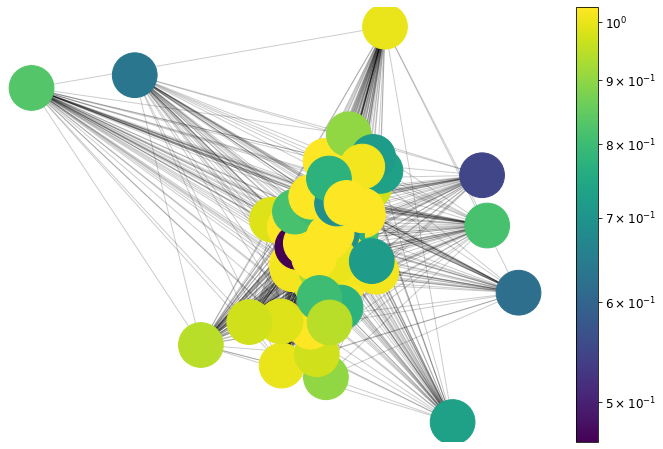

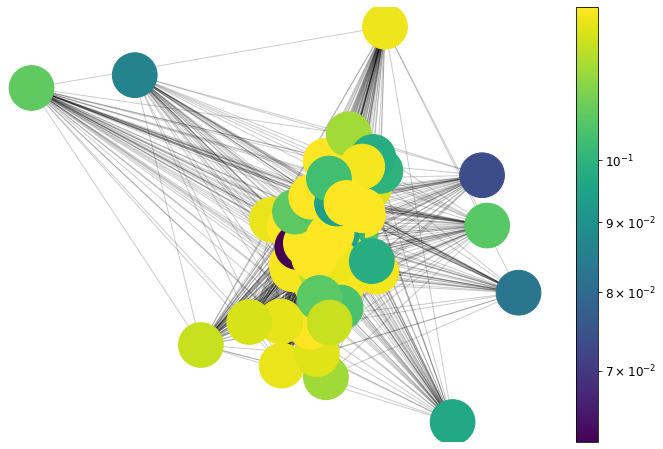

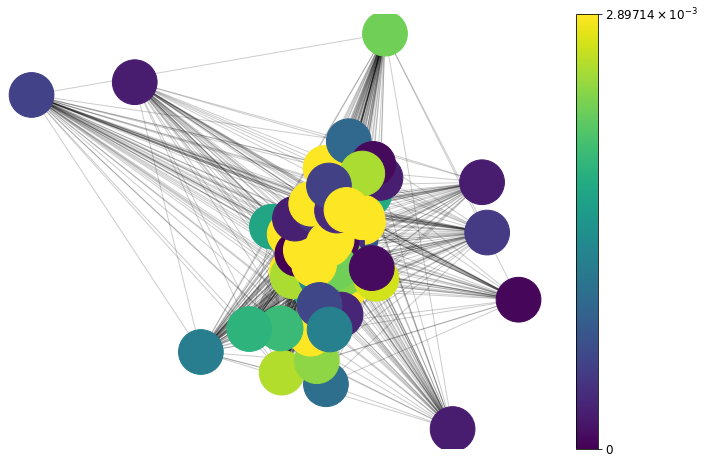

In [10]:
## centrality plot function
%matplotlib inline
def draw(G, pos, measures, measure_name):
    labels = nx.get_edge_attributes(G, "weight")
    nodes = nx.draw_networkx_nodes(G, pos, node_size=2000, 
                                   #cmap=plt.cm.plasma, 
                                   #node_color=labels,
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys(), 
                                   with_labels = True)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)

    #plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

plt.rcParams["figure.figsize"] = (12,8)
G = u.graph
pos = nx.spring_layout(G, seed = 1)
DiG = nx.DiGraph()

## test cases
draw(G, pos, nx.degree_centrality(G), 'Degree Centrality')
draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

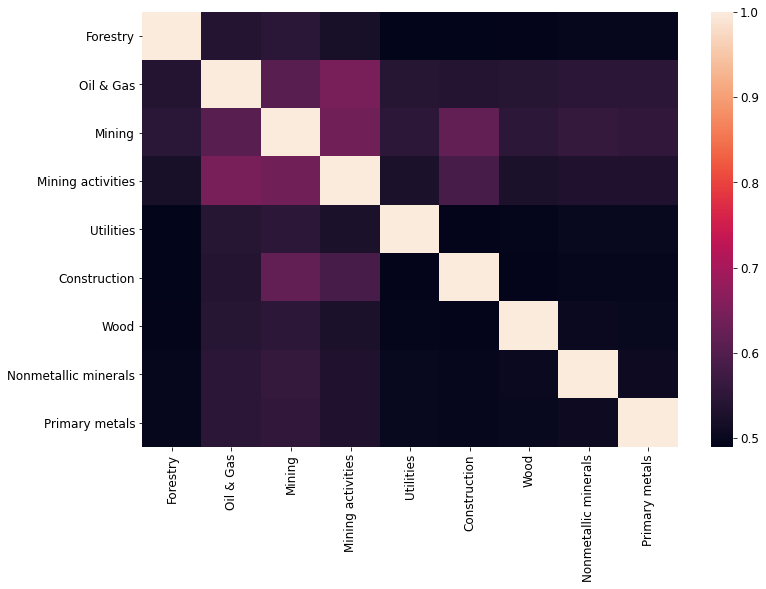

In [11]:
df = s.table
corr = df.iloc[:,1:10].corr()
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns,
                yticklabels=corr.columns)